# Data

In [300]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
import yfinance as yf
import os

In [301]:
data = yf.download('XRP-USD', start='2020-11-30', end='2022-11-30')

[*********************100%***********************]  1 of 1 completed


In [302]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-30,0.606289,0.672179,0.600425,0.664337,0.664337,17398359053
2020-12-01,0.664515,0.679158,0.594348,0.612923,0.612923,16985355820
2020-12-02,0.612992,0.635897,0.598636,0.629893,0.629893,12874875863
2020-12-03,0.629995,0.640333,0.616173,0.631483,0.631483,9884297219
2020-12-04,0.631469,0.632967,0.546687,0.557262,0.557262,9629062989


In [303]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-25,0.401982,0.416910,0.390233,0.408412,0.408412,1269230070
2022-11-26,0.408410,0.412276,0.395086,0.396629,0.396629,614794664
2022-11-27,0.396606,0.407911,0.395971,0.396821,0.396821,630018233
2022-11-28,0.396801,0.398779,0.375520,0.390318,0.390318,1179083829
2022-11-29,0.390279,0.402976,0.384255,0.398549,0.398549,969049648


In [304]:
Ri_1 = data['Adj Close'] # I have created a new data value for less months range
Ri_1.tail()

Date
2022-11-25    0.408412
2022-11-26    0.396629
2022-11-27    0.396821
2022-11-28    0.390318
2022-11-29    0.398549
Name: Adj Close, dtype: float64

array([<AxesSubplot:xlabel='Date'>], dtype=object)

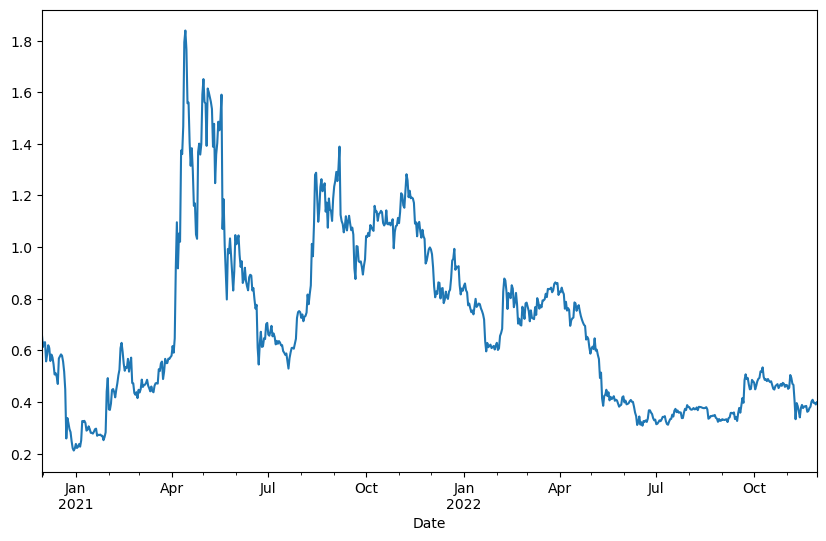

In [305]:
Ri_1.plot(figsize=(10, 6), subplots=True)

In [306]:
RIPLMin = Ri_1[-92:-1] # Here a new value shows 3 months price of Ripple, there i have used *92-1
RIPLMin

Date
2022-08-30    0.326869
2022-08-31    0.327870
2022-09-01    0.333194
2022-09-02    0.331259
2022-09-03    0.329969
                ...   
2022-11-24    0.401992
2022-11-25    0.408412
2022-11-26    0.396629
2022-11-27    0.396821
2022-11-28    0.390318
Name: Adj Close, Length: 91, dtype: float64

In [307]:
log_return = np.log(RIPLMin / RIPLMin.shift(1)) # I have used Log return of 3 months because it is symmetric and used for financial calculation. 
log_return


Date
2022-08-30         NaN
2022-08-31    0.003058
2022-09-01    0.016108
2022-09-02   -0.005824
2022-09-03   -0.003902
                ...   
2022-11-24    0.052109
2022-11-25    0.015844
2022-11-26   -0.029275
2022-11-27    0.000484
2022-11-28   -0.016523
Name: Adj Close, Length: 91, dtype: float64

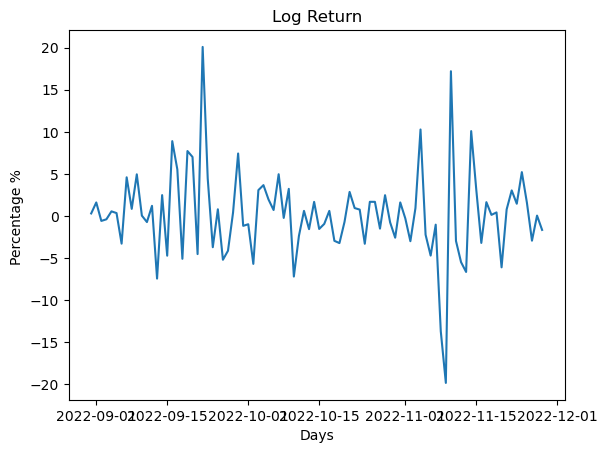

In [308]:
fig = plt.figure()
plt.plot(log_return * 100)
plt.xlabel('Days')
plt.ylabel('Percentage % ')
plt.title('Log Return');

In [309]:
vol = np.sqrt(365) * log_return.std() # I have changed the days value to 365 to calculate annual volatility
print('The annualised volatility is', round(vol*100,2), '%')

The annualised volatility is 101.05 %


In [310]:
S0 = RIPLMin[-1]      #Here i have calculated my recent spot price
S0

0.39031800627708435

# Binomial Tree

In [311]:
S = S0                  # spot price
K = 0.50                # strike
T = 3/12                # maturity 
r = 4.353/100           # risk free rate 
sigma = vol             # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "call"         # payoff 

In [312]:
dT = float(T) / N                             # Delta t
u = np.exp(sigma * np.sqrt(dT))               # up factor
d = 1.0 / u                                   # down factor 
print ('Crypto Price movement UP factor %s and DOWN factors %s ' %(u,d))

Crypto Price movement UP factor 1.338725261813989 and DOWN factors 0.7469792559565118 


In [313]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [314]:
S # Up and down movement of Binomial Tree

array([[0.39031801, 0.52252858, 0.6995222 , 0.93646805],
       [0.        , 0.29155945, 0.39031801, 0.52252858],
       [0.        , 0.        , 0.21778886, 0.29155945],
       [0.        , 0.        , 0.        , 0.16268376]])

In [315]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.4337246535572114

In [316]:
print('Probability for moving up : ',p)
print('Probability for moving down : ',q)

Probability for moving up :  0.4337246535572114
Probability for moving down :  0.5662753464427885


# Step 2: Find option values at each node.

In [317]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[0.        , 0.        , 0.        , 0.43646805],
       [0.        , 0.        , 0.        , 0.02252858],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [318]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[0.04234814, 0.09249994, 0.20133267, 0.43646805],
       [0.        , 0.00420737, 0.00973582, 0.02252858],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [319]:
print('European ' + payoff, str( V[0,0]))

European call 0.04234814082774611


# Monte Carlo

In [320]:
def mcs_simulation_np(m,n):       #m is the number of steps and n is the number of simulation
    M = m
    I = n
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [321]:
S = mcs_simulation_np(90,10000)

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

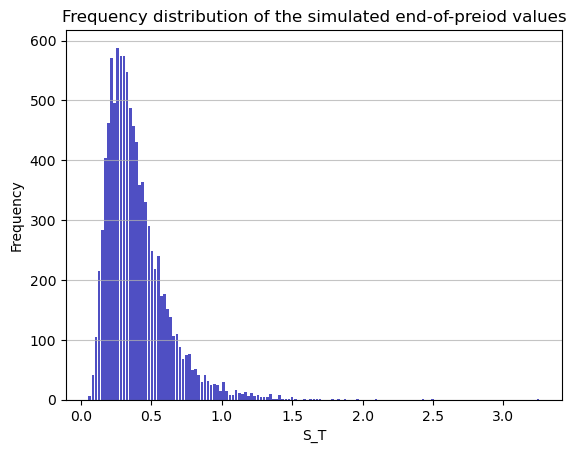

In [322]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[-1,:], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [323]:
p = np.mean(np.maximum(S[-1,:] - K,0))
print('European call', str(p))

European call 0.04634658087564205


# Black Scholes

In [324]:
def euro_option_bs(S, K, T, r, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [325]:
bsp = euro_option_bs(S0,0.50,3/12,4.353/100,vol, "call")
print('European put option price using BSM is $', bsp)

European put option price using BSM is $ 0.045372367219007156


# European Call prices (XRP-USD)

In [331]:
print(' Binomial price tree method - Eurpoean put price for XRP-USD wiht 1 week expiry  ' , str( V[0,0].round(4)))
print(' Monte Carlo Simulation method -Eurpoean put price for XRP-USD with 1 week expiry  ', str(p.round(4)))
print(' BSM method - Eurpoean put price for XRP-USD with 1 week expiry  ', bsp.round(4))

 Binomial price tree method - Eurpoean put price for XRP-USD wiht 1 week expiry   0.0423
 Monte Carlo Simulation method -Eurpoean put price for XRP-USD with 1 week expiry   0.0463
 BSM method - Eurpoean put price for XRP-USD with 1 week expiry   0.0454


In [338]:
Call_prices=( float( V[0,0].round(4)),(p.round(4)),bsp)
Call_price1 = pd.DataFrame (Call_prices)

In [339]:
Call_price1['Method'] = ('Binomial Price Tree ', 'Monte Carlo','Black Scholes Model')
Call_price1.columns = ['Price','Method' ]
Call_price1

,Price,Method
0,0.042300,Binomial Price Tree
1,0.046300,Monte Carlo
2,0.045372,Black Scholes Model


# Greeks

# Delta

In [340]:
from mpl_toolkits.mplot3d import Axes3D

In [398]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(- q * T) * si.norm.cdf(d1, 0.0, 1.0)
    return delta

In [399]:
S = S0                  # spot stock price
K = 0.50                # strike
T = 3/12                # maturity 
r = 4.353/100           # risk free rate 
sigma = vol             # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "call"         # payoff 

In [400]:
delta(S, K, T, r, q, vol, payoff)

0.26899054320589305

In [401]:
d = delta(S, K, T, r, q, vol, payoff)
print('The value of Delta is', d.round(4),'.','If the stock price increase 1 dollar, then the value of the option will increase $', d.round(4), '.')

The value of Delta is 0.269 . If the stock price increase 1 dollar, then the value of the option will increase $ 0.269 .


In [402]:
S = np.linspace(0.1, 1, 10)
T = np.linspace(1/12, 2/12, 11)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], K, T[i], r , q, vol, 'call')

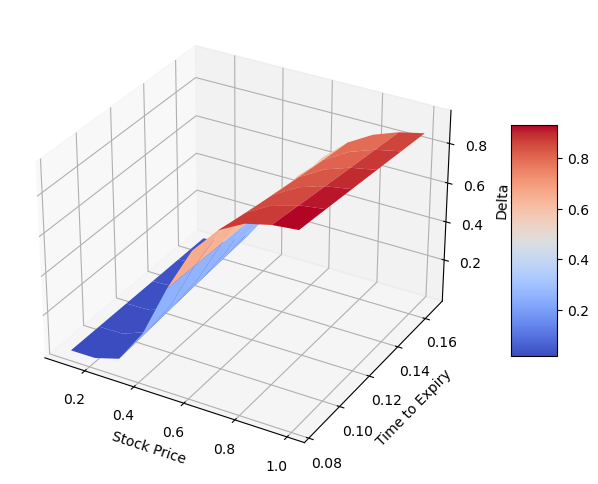

In [403]:

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Gamma

In [347]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- r * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [348]:
S = S0                  # spot stock price
K = 0.50                # strike
T = 3/12                # maturity 
r = 4.353/100           # risk free rate 
sigma = vol             # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "call"         # payoff 

In [349]:
g = gamma(S, K, T, r, q, vol, payoff)
print('The value of Gamma is', g.round(4),'.','If the stock price increase 1 dollar, then the value of the option will increase $', g.round(4), '.')

The value of Gamma is 1.7693 . If the stock price increase 1 dollar, then the value of the option will increase $ 1.7693 .


In [404]:
S = np.linspace(0.3, 1, 10)
T = np.linspace(1/12, 2/12, 11)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], K, T[i], r, q, vol, 'call')

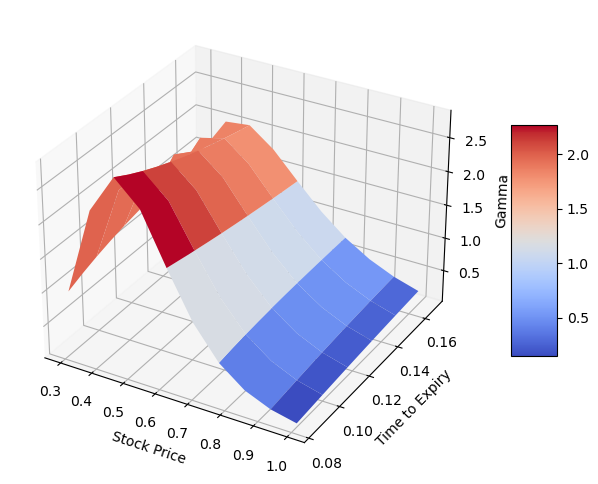

In [405]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S,T  = np.meshgrid(S,T)
surf = ax.plot_surface(S,T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Speed

In [352]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [353]:
S = S0                  # spot stock price
K = 0.50                # strike
T = 3/12                # maturity 
r = 4.353/100           # risk free rate 
sigma = vol             # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "call"         # payoff 

In [354]:
sp = speed(S, K, T, r, q, vol, payoff)
print('The value of Speed is', sp.round(4),'.','If the stock price increase 1 dollar, then the value of gamma will increase ', sp.round(4), '.')

The value of Speed is -0.0359 . If the stock price increase 1 dollar, then the value of gamma will increase  -0.0359 .


In [406]:
S = np.linspace(0.3, 1, 10)
T = np.linspace(1/12, 2/12, 11)
Speed = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Speed[i,j] = speed(S[j], K, T[i], r, q, vol, 'call')

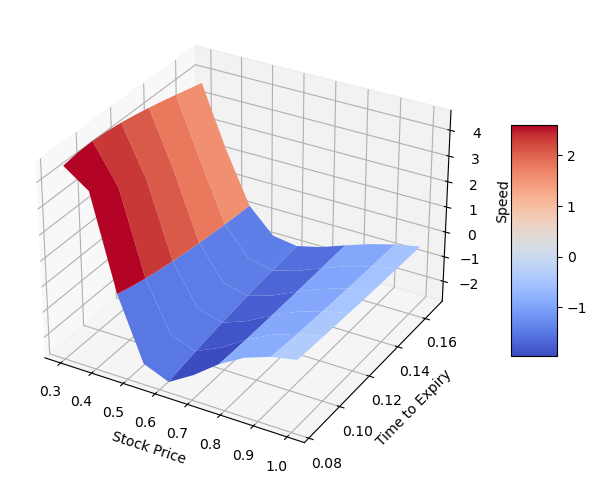

In [407]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S,T  = np.meshgrid(S,T)
surf = ax.plot_surface(S,T, Speed, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);


# Theta

In [357]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) + q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) - r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [358]:
S = S0                  # spot stock price
K = 0.50                # strike
T = 3/12                # maturity 
r = 4.353/100           # risk free rate 
sigma = vol             # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "call"         # payoff 

In [359]:
th = theta(S, K, T, r, q, vol, payoff)
th1 = th/52

In [360]:
print('The value of Theta is', th.round(4),'.','If the time increase by 1 week, then the value of the option will increase $', th1.round(4), '.')

The value of Theta is 0.0647 . If the time increase by 1 week, then the value of the option will increase $ 0.0012 .


In [408]:
S = np.linspace(0.3, 1, 10)
T = np.linspace(1/12, 2/12, 11)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], K, T[i], r, q, vol, 'call')

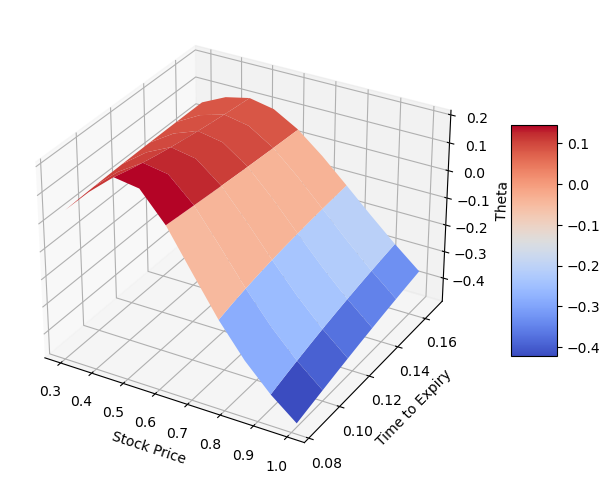

In [409]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S,T  = np.meshgrid(S,T)
surf = ax.plot_surface(S,T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Rho

In [363]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [392]:
S = S0                  # spot stock price
K = 0.50                # strike
T = 3/12                # maturity 
r = 4.353/100           # risk free rate 
sigma = vol             # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "call"         # payoff 

In [393]:
rh = rho(S, K, T, r, q, vol, payoff)
rh1 = rh/100

In [394]:
print('The value of Rho is', rh.round(4),'.','If the interest rate by 1 percent, then the value of the option will increase $', rh1.round(4), '.')

The value of Rho is 0.0196 . If the interest rate by 1 percent, then the value of the option will increase $ 0.0002 .


In [410]:
S = np.linspace(0.3, 1, 10)
T = np.linspace(1/12, 2/12, 11)
Rho = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Rho[i,j] = rho(S[j], K, T[i], r, q, vol, 'call')

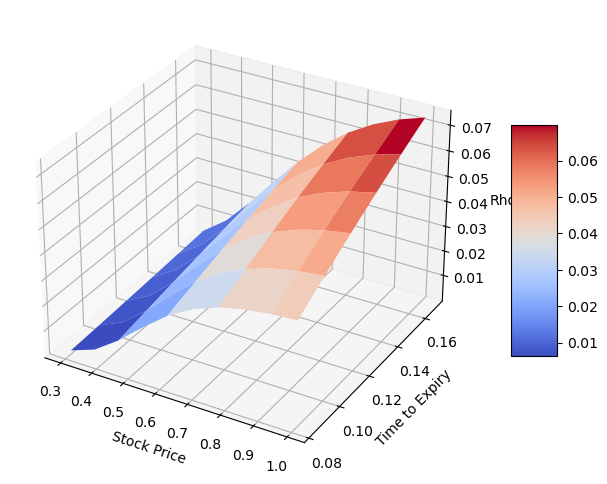

In [411]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Rho, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Vega

In [461]:
def vega(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [462]:
S = S0                  # spot stock price
K = 0.50                # strike
T = 3/12                # maturity 
r = 4.353/100           # risk free rate 
sigma = vol             # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "call"         # payoff 

In [463]:
v = vega(S, K, T, r, q, vol, payoff)
print('The value of Vega is', v.round(4),'.','If the volatility increases 1%, then the value of the option will increase $', v.round(4)*0.01, '.')

The value of Vega is 0.0598 . If the volatility increases 1%, then the value of the option will increase $ 0.000598 .


In [464]:
S = np.linspace(0.3, 1, 10)
T = np.linspace(1/12, 2/12, 11)
Vega = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Vega[i,j] = vega(S[j], K, T[i], r, q, vol, 'call')

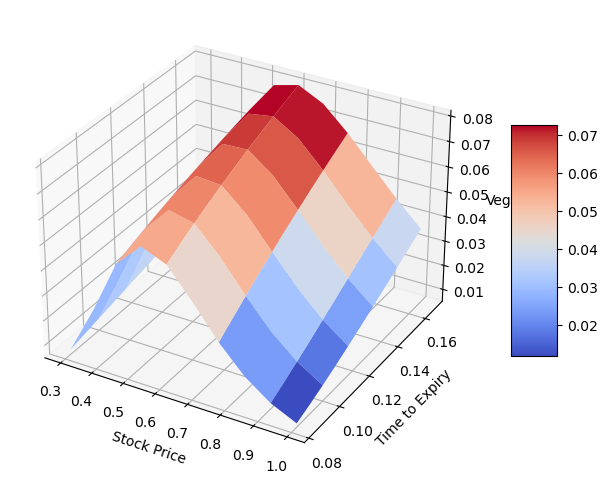

In [465]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Vega, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);


# END